# Biopsy Prostate Cancer Detection - ML

Data in the CSV files:

- **image_id:** ID code for the image.

- **data_provider:** The name of the institution that provided the data. Both the Karolinska Institute and Radboud University Medical Center contributed data. They used different scanners with slightly different maximum microscope resolutions and worked with different pathologists for labeling their images.

- **isup_grade:** Train only. The target variable. The severity of the cancer on a 0-5 scale.

- **gleason_score:** Train only. An alternate cancer severity rating system with more levels than the ISUP scale. For details on how the gleason and ISUP systems compare, see the Additional Resources tab.

There are two different data providers that clasify the grade of the tumour differently:

**Radboud:** Prostate glands are individually labelled. Valid values are:
- 0: background (non tissue) or unknown
- 1: stroma (connective tissue, non-epithelium tissue)
- 2: healthy (benign) epithelium
- 3: cancerous epithelium (Gleason 3)
- 4: cancerous epithelium (Gleason 4)
- 5: cancerous epithelium (Gleason 5)

**Karolinska:** Regions are labelled. Valid values are:
- 0: background (non tissue) or unknown
- 1: benign tissue (stroma and epithelium combined)
- 2: cancerous tissue (stroma and epithelium combined)

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import skimage.io
from skimage.transform import resize, rescale
import cv2
from PIL import Image
import imagecodecs
import random
import matplotlib.image as mpimg
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator

In [2]:
train_csv = pd.read_csv('train.csv')

train_csv.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [3]:
train_csv.isna().sum()

image_id         0
data_provider    0
isup_grade       0
gleason_score    0
dtype: int64

In [4]:
train_csv['gleason_score'].value_counts()

3+3         2666
0+0         1925
3+4         1342
4+3         1243
4+4         1126
negative     967
4+5          849
5+4          248
5+5          127
3+5           80
5+3           43
Name: gleason_score, dtype: int64

In [5]:
train_csv['data_provider'].value_counts()

karolinska    5456
radboud       5160
Name: data_provider, dtype: int64

In [6]:
train_csv['isup_grade'].value_counts()

0    2892
1    2666
2    1343
4    1249
3    1242
5    1224
Name: isup_grade, dtype: int64

##### Data in the train CSV seems to be very clean, with same number of rows for each data provider and high number of cases for each isup_grade. 

In [7]:
train_clean = pd.DataFrame()

In [8]:
train_csv['path'] = train_csv['image_id'] +'.png'

In [9]:
train_csv.head()

,image_id,data_provider,isup_grade,gleason_score,path
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,0005f7aaab2800f6170c399693a96917.png
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,000920ad0b612851f8e01bcc880d9b3d.png
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,0018ae58b01bdadc8e347995b69f99aa.png
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,001c62abd11fa4b57bf7a6c603a11bb9.png
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,001d865e65ef5d2579c190a0e0350d8f.png


In [10]:
train_csv['binary_score'] = np.where(
    (train_csv['data_provider'] == 'karolinska') & (train_csv['isup_grade'] < 3), 'benigno', 
    np.where((train_csv['data_provider'] == 'radboud') & (train_csv['isup_grade'] < 1), 'benigno' , 
    'maligno'))

In [11]:
train_csv.head()

,image_id,data_provider,isup_grade,gleason_score,path,binary_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,0005f7aaab2800f6170c399693a96917.png,benigno
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,000920ad0b612851f8e01bcc880d9b3d.png,benigno
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,0018ae58b01bdadc8e347995b69f99aa.png,maligno
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,001c62abd11fa4b57bf7a6c603a11bb9.png,maligno
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,001d865e65ef5d2579c190a0e0350d8f.png,benigno


In [12]:
train_clean = pd.DataFrame(train_csv[['path', 'binary_score']])
train_clean.head()

,path,binary_score
0,0005f7aaab2800f6170c399693a96917.png,benigno
1,000920ad0b612851f8e01bcc880d9b3d.png,benigno
2,0018ae58b01bdadc8e347995b69f99aa.png,maligno
3,001c62abd11fa4b57bf7a6c603a11bb9.png,maligno
4,001d865e65ef5d2579c190a0e0350d8f.png,benigno


In [13]:
#this is for test purposes only
train_clean_small = train_clean[:1000]
train_clean_small

,path,binary_score
0,0005f7aaab2800f6170c399693a96917.png,benigno
1,000920ad0b612851f8e01bcc880d9b3d.png,benigno
2,0018ae58b01bdadc8e347995b69f99aa.png,maligno
3,001c62abd11fa4b57bf7a6c603a11bb9.png,maligno
4,001d865e65ef5d2579c190a0e0350d8f.png,benigno
...,...,...
995,1987d293a6345a3fdfd2accf524bc2d1.png,benigno
996,198fa06f052feedc1684e42829c137fc.png,maligno
997,1990f9eb40f798dcb50f7fad287c0e28.png,maligno
998,19929dc431ae4560780d6a92a8e9fd20.png,maligno


-------------------------------------------------------

# Image treatment

These images are in a .tiff format, which is good for maintaining good quality in the images, but the size is too big fo be feasible to create a model (at least an initial one). I will transform these images into .png and also will convert them to have the same size (512x512), as they have a wide variety of sizes and forms.

In [14]:
# where are the images
data_dir = "train_images/"

In [15]:
# where will the converted images be stored, create the folder if it doesn't exist
save_dir = "png_images/"
os.makedirs(save_dir, exist_ok=True)

In [16]:
# THIS HAS ALREADY BEEN DONE! No need to run it again and again. It converts the images.

# for img_id in tqdm(train_csv.image_id):
#     load_path = data_dir + img_id + '.tiff'
#     save_path = save_dir + img_id + '.png'
    
#     biopsy = skimage.io.MultiImage(load_path)
#     img = cv2.resize(biopsy[-1], (0,0), fx = 0.1, fy = 0.1)
#     cv2.imwrite(save_path, img)

In [17]:
datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.2)

In [18]:
train_generator  = datagen.flow_from_dataframe(
    dataframe=train_clean_small,
    directory=save_dir,
    x_col="path",
    y_col="binary_score",
    target_size=(512, 512),
    color_mode="rgb",
    batch_size=64,
    save_to_dir='png_images_resized/',
    save_format="png",
    class_mode="binary",
    subset='training'
)


validation_generator  = datagen.flow_from_dataframe(
    dataframe=train_clean_small,
    directory=save_dir,
    x_col="path",
    y_col="binary_score",
    target_size=(512, 512),
    color_mode="rgb",
    batch_size=64, #deberia ser mas alto que el del modelo (sugerencia)
    save_to_dir='png_images_resized/',
    save_format="png",
    class_mode="binary",
    subset='validation'
)

Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


In [20]:
# Now the images are all of the same shape and lighter

# files = os.listdir(save_dir)
# d = random.choice(files)

# img = mpimg.imread(save_dir + d)
# imgplot = plt.imshow(img)
# plt.show()

In [21]:
# from keras.preprocessing import image

# # reading the training images

# train_image = [ ]

# for i in tqdm(range(train_csv.shape[0])):

#     img = image.load_img('png_images/' + train_csv['image_id'][i] + '.png', target_size = (512,512,1), 
#             grayscale = False)

#     img = image.img_to_array(img)

#     img = img/255

#     train_image.append(img)
#     X = np.array(train_image)

In [22]:
# X.shape

In [23]:
# y = train_csv['isup_grade'].values

In [24]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

----------

# Modeling

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(512, 512, 3)),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [26]:
model.compile(optimizer='adam', 
              loss="binary_crossentropy", 
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 510, 510, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 255, 255, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 253, 253, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 1016064)           0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1016065   
Total params: 1,035,457
Trainable params: 1,035,457
Non-trainable params: 0
______________________________________________

-----

# Model Training

In [28]:
# history = model.fit(X_train, 
#                     y_train, 
#                     batch_size=64, 
#                     epochs=100, 
#                     validation_data=(X_test, y_test))

history = model.fit(
    train_generator,
    validation_data = validation_generator,
    batch_size=64,
    epochs = 10)

Epoch 1/10
13/13 [==============================] - 169s 13s/step - loss: 12.3446 - accuracy: 0.4899 - val_loss: 0.7505 - val_accuracy: 0.5150
Epoch 2/10
13/13 [==============================] - 153s 12s/step - loss: 0.7112 - accuracy: 0.5663 - val_loss: 0.6173 - val_accuracy: 0.6450
Epoch 3/10
13/13 [==============================] - 158s 12s/step - loss: 0.6130 - accuracy: 0.6560 - val_loss: 0.5839 - val_accuracy: 0.7250
Epoch 4/10
13/13 [==============================] - 156s 13s/step - loss: 0.5068 - accuracy: 0.7714 - val_loss: 0.5582 - val_accuracy: 0.7350
Epoch 5/10
13/13 [==============================] - 159s 12s/step - loss: 0.4433 - accuracy: 0.8132 - val_loss: 0.6268 - val_accuracy: 0.6500
Epoch 6/10
13/13 [==============================] - 175s 13s/step - loss: 0.3462 - accuracy: 0.8275 - val_loss: 0.5058 - val_accuracy: 0.7900
Epoch 7/10
13/13 [==============================] - 99s 8s/step - loss: 0.2109 - accuracy: 0.9213 - val_loss: 0.6021 - val_accuracy: 0.7400
Epoch 8

In [29]:
def plot_training(history, metrics: list = ('loss',), figsize: tuple = (12, 5)):
    """
    plots training selected metrics for every batch
    """
    epochs = range(1, len(history.history[metrics[0]]) + 1)

    fig, ax_arr = plt.subplots(1, len(metrics), figsize=figsize)

    if not isinstance(ax_arr, np.ndarray):
        ax_arr = np.array(ax_arr).reshape(1, )

    for i, metric in enumerate(metrics):
        ax_arr[i].plot(epochs, history.history[metric], color='k', linestyle='solid', label=metric, linewidth=2)
        ax_arr[i].plot(epochs, history.history[f"val_{metric}"], color='r', linestyle='dotted',
                       label=f'validation {metric}')
        ax_arr[i].set_ylabel(metric)
        ax_arr[i].set_xlabel('epochs')
        ax_arr[i].grid()
        ax_arr[i].legend()
    plt.show()

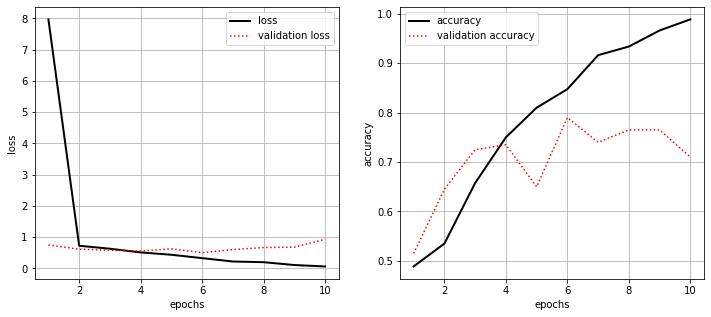

In [30]:
plot_training(history, metrics=['loss', 'accuracy'])

In [242]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

NameError: name 'X_test' is not defined

In [243]:
test_accuracy

NameError: name 'test_accuracy' is not defined

In [26]:
# Same for label masks 
# data_masks_dir = "train_label_masks/"

In [27]:
# save_mask_dir = "png_masks/"
# os.makedirs(save_maks_dir, exist_ok=True)

# mask_files = os.listdir(data_masks_dir)

In [28]:
# for mask_file in tqdm(mask_files):
#     load_path = data_masks_dir + mask_file
#     save_path = save_mask_dir + mask_file.replace('.tiff', '.png')
    
#     mask = skimage.io.MultiImage(load_path)
#     img = cv2.resize(mask[-1], (512, 512))
#     cv2.imwrite(save_path, img)